# Learning Model (SVD)
Now that we've implemented naive user-based CF, we'll implement a more advanced model - the SVD model.

INSERT DESCRIPTION HERE

One disadvantage of the SVD model is that it can't generalize to unseen items - predictions rely on item and user factors which are learned during model training. When training our model, 

In [1]:
%%capture
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
# import packages
from utils.imports import *
# import SVD model
from models.SVD import SVD

In [2]:
# import pandas dataframes
with open("../data/dataframes.pkl", "rb") as f:
    data = pickle.load(f)

train = data["train"]
validation = data["validation"]
baseline = data["baseline"]

# load sparse matrix
ui_csr = load_npz("../data/ui_csr.npz")

# load encodings
with open("../artifacts/user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)
with open("../artifacts/item_encoder.pkl", "rb") as f:
    item_encoder = pickle.load(f)
with open("../artifacts/user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("../artifacts/item_map.pkl", "rb") as f:
    item_map = pickle.load(f)

In [3]:
test = SVD(k=25)
test.fit(ui_csr, validation)

Iteration: 1
current validation RMSE: 0.7317920408414402
Iteration: 2
current validation RMSE: 0.7206272282396056
Iteration: 3
current validation RMSE: 0.7141279711252951
Iteration: 4
current validation RMSE: 0.7098144690578604
Iteration: 5
current validation RMSE: 0.7065895606032799
Iteration: 6
current validation RMSE: 0.7039377070625594
Iteration: 7
current validation RMSE: 0.7018876902872431
Iteration: 8
current validation RMSE: 0.7002251330605309
Iteration: 9
current validation RMSE: 0.6990457408862825
Iteration: 10
current validation RMSE: 0.6979591741035881
Iteration: 11
current validation RMSE: 0.6970643828928453
Iteration: 12
current validation RMSE: 0.6960675897377442
Iteration: 13
current validation RMSE: 0.6952588131623019
Iteration: 14
current validation RMSE: 0.6945538754005154
Stopped after 15 iterations
Final RMSE is: 0.6941537976554261 with 25 latent factors, 0.005 learning rate, 0.02 reg. parameter


0.4916

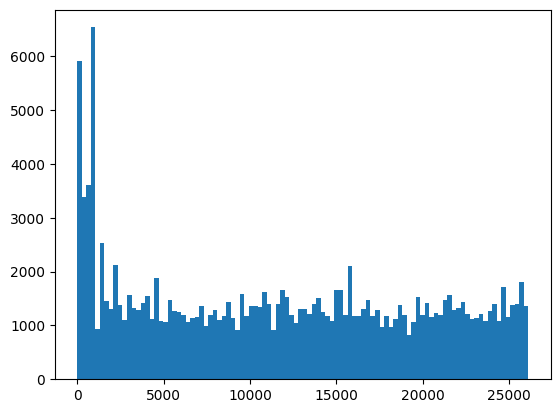

In [4]:
test.top_N_coverage()

In [7]:
ui_csr.nonzero()

(array([    0,     0,     0, ..., 14555, 14555, 14555],
       shape=(1412949,), dtype=int32),
 array([ 16,  27, 132, ...,  98, 190, 695], shape=(1412949,), dtype=int32))

In [ ]:
# this grid search will take a long time to run
k_grid = np.array([10,25,50,75])
reg_grid = np.array([0.001, 0.02, 0.1])
grid = itertools.product(k_grid, reg_grid)
models = []
for k, reg in grid:
    models = SVD(k=k, reg=reg).fit(ui_csr, validation, verbose=False)
    

Iteration: 1
current validation RMSE: 0.7312099517256151
Iteration: 2
current validation RMSE: 0.7200292194716162
Iteration: 3
current validation RMSE: 0.7138609267412769
Iteration: 4
current validation RMSE: 0.7093988395771685
Iteration: 5
current validation RMSE: 0.7060963390907078
Iteration: 6
current validation RMSE: 0.7037724824565518
Iteration: 7
current validation RMSE: 0.7016119143102296
Iteration: 8
current validation RMSE: 0.7001274759429831
Iteration: 9
current validation RMSE: 0.6987986685093419
Iteration: 10
current validation RMSE: 0.6975925873088867
Stopped after 11 iterations
Final RMSE is: 0.6970803696464634 with 10 latent factors, 0.005 learning rate, 0.001 reg. parameter
Iteration: 1
current validation RMSE: 0.7312525597029311
Iteration: 2
current validation RMSE: 0.7199687907541383
Iteration: 3
current validation RMSE: 0.7137267395096859
Iteration: 4
current validation RMSE: 0.7092217660028238
Iteration: 5
current validation RMSE: 0.7058531249341766


KeyboardInterrupt: 

1 2 3
1 1 1


array([[1, 1],
       [2, 1],
       [3, 1]])